In [38]:
import torch
import torch.nn as nn
import random
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import time
from nnmodels import get_model
from train_eval import train, model_eval
from sklearn.metrics import recall_score, precision_score, accuracy_score

In [39]:
all_metrics = {
    'acc': accuracy_score,
    'prec': precision_score,
    'recall': recall_score
}

#### Define data augmentations

In [40]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32,32)),
    # transforms.ColorJitter(brightness=(0.5,1.5),contrast=(1),saturation=(0.5,1.5),hue=(-0.1,0.1)),
    transforms.RandomAffine(0, shear=0.2),         # random shear 0.2
    transforms.RandomAffine(0, scale=(0.8, 1.2)),  # random zoom 0.2
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),   
    transforms.RandomVerticalFlip(),     
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32,32)),
])
vis_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [41]:
train_dataset = torchvision.datasets.ImageFolder(root='train', transform=train_transforms)
valid_dataset = torchvision.datasets.ImageFolder(root='val', transform=test_transform)
test_dataset = torchvision.datasets.ImageFolder(root='test', transform=test_transform)
print(train_dataset.class_to_idx)
reversemapping = {a:b for b,a in train_dataset.class_to_idx.items()}
assert train_dataset.class_to_idx == valid_dataset.class_to_idx == test_dataset.class_to_idx

{'paper': 0, 'rock': 1, 'scissors': 2}


#### Visualizing training data

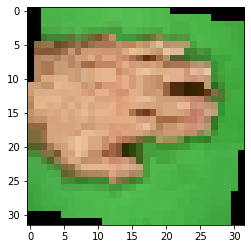

In [42]:
plt.imshow(train_dataset[0][0].permute(1,2,0))

In [43]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=256, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256*2, shuffle=False)

#### Definie Hyper-paramters

In [44]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print('We are using {} for training, note that cpu may be slow for training.'.format(device))
model = get_model('base')
model = model.to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=0.001, weight_decay=5e-6)
total_epochs = 20
# scheduler = MultiStepLR(optimizer, milestones=[10,], gamma=0.1)
scheduler = None

We are using cuda for training, note that cpu may be slow for training.


#### Model training

In [45]:
best_val_acc = 0.0
final_test_acc = 0.0
for epoch in range(total_epochs):
    train(model, loss, optimizer, train_loader, device, epoch, False, scheduler=scheduler)
    _, val_acc = model_eval(model, loss, val_loader, device, name= 'Valid')
    _, test_acc = model_eval(model, loss, test_loader, device, name= 'Test')
    if val_acc > best_val_acc:
        print('A better Valid Acc is found: {} with Test Acc {}'.format(val_acc, test_acc))
        best_val_acc = val_acc
        final_test_acc = test_acc
        torch.save(model.state_dict(), 'best_model_nojit.ckpt')

Epoch: 0, Train: Top 1 Accuracy: 1099/1531 (71.78%), Time Used: 0.1352518876393636 mins
Valid Evaluation: Average loss: 2.1007, Top 1 Accuracy: 109/328 (33.23%)
Test Evaluation: Average loss: 2.0876, Top 1 Accuracy: 109/329 (33.13%)
A better Valid Acc is found: 33.23170731707317 with Test Acc 33.130699088145896
Epoch: 1, Train: Top 1 Accuracy: 1441/1531 (94.12%), Time Used: 0.10486183563868205 mins
Valid Evaluation: Average loss: 0.6438, Top 1 Accuracy: 230/328 (70.12%)
Test Evaluation: Average loss: 0.6303, Top 1 Accuracy: 232/329 (70.52%)
A better Valid Acc is found: 70.1219512195122 with Test Acc 70.51671732522796
Epoch: 2, Train: Top 1 Accuracy: 1457/1531 (95.17%), Time Used: 0.10355172952016195 mins
Valid Evaluation: Average loss: 0.4379, Top 1 Accuracy: 279/328 (85.06%)
Test Evaluation: Average loss: 0.4387, Top 1 Accuracy: 278/329 (84.50%)
A better Valid Acc is found: 85.0609756097561 with Test Acc 84.4984802431611
Epoch: 3, Train: Top 1 Accuracy: 1462/1531 (95.49%), Time Used: 

#### Model results

In [46]:
print('The best Valid Acc: {}, Test Acc: {}'.format(best_val_acc, final_test_acc))

The best Valid Acc: 99.6951219512195, Test Acc: 99.3920972644377


In [47]:
model.load_state_dict(torch.load('best_model_nojit.ckpt'))

<All keys matched successfully>

In [22]:
for data, y in test_loader:
    pred = model(data.cuda()).argmax(1).cpu().numpy()
    actual = y.numpy()

In [26]:
precision = precision_score(actual, pred, average=None)
print(precision)

[0.99056604 1.         0.98245614]


In [27]:
recall = recall_score(actual, pred, average=None)
print(recall)

[0.98130841 1.         0.99115044]


#### Check Wrong solutions

In [127]:
from torchvision.utils import save_image
i = 0
model.eval()
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, pred = output.topk(1, dim=1)
        print((torch.logical_not(pred.eq(target.view(-1,1))).view(-1)).nonzero(as_tuple=True)[0])

        for image, prediction in zip(data[torch.logical_not(pred.eq(target.view(-1,1))).view(-1)], pred[torch.logical_not(pred.eq(target.view(-1,1))).view(-1)]):
            save_image(image, reversemapping[prediction.item()]+str(i)+'.png')
            i += 1
        break

tensor([ 32, 104, 246], device='cuda:0')


In [47]:
from torchvision.utils import save_image
for i in data[torch.logical_not(pred.eq(target.view(-1,1))).view(-1)]:
    save_image(i, 'img1.png')

#### Testing results

We are choosing 259/329 for testing with target: scissors.


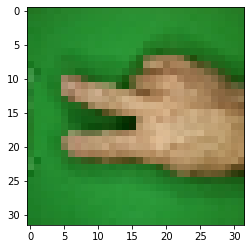

In [9]:
data_len = len(test_dataset)
index = random.randint(0, data_len)
data, target = test_dataset[index]
print('We are choosing {}/{} for testing with target: {}.'.format(index+1, data_len, reversemapping[target]))
plt.imshow(data.permute(1,2,0))

In [10]:
model.eval()
print('Our network prediction is: {}'.format(reversemapping[model(data.unsqueeze(0).cuda()).argmax(1).item()]))

Our network prediction is: scissors


#### Real images testing

In [48]:
import numpy as np

In [49]:
real_dataset= torchvision.datasets.ImageFolder('real', transform=test_transform)
real_loader = torch.utils.data.DataLoader(real_dataset, batch_size=100, shuffle=False)
real_vis_dataset=  torchvision.datasets.ImageFolder('real', transform=vis_transform)
real_vis_loader = torch.utils.data.DataLoader(real_vis_dataset, batch_size=100, shuffle=False)

In [50]:
for data, y in real_loader:
    pred = model(data.cuda()).argmax(1).cpu().numpy()
    actual = y.numpy()

for metric_name, metric_func in all_metrics.items():
    print(metric_name)
    try:
        print(metric_func(actual, pred, average=None))
    except:
        print(metric_func(actual, pred))

acc
0.35714285714285715
prec
[0.35714286 0.         0.        ]
recall
[1. 0. 0.]


c:\software\anaconda\main\envs\py39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
# total = 0
# correct = 0
# for (x,y), (x_vis, y_vis) in zip(real_loader,real_vis_loader):
#     plt.figure()
#     # plt.imshow(x_vis[0].permute(1,2,0))
#     total += 1
#     correct += model(x.cuda()).argmax(1).item() == y.item()
#     # print('Our network prediction is: {}, acutal is: {}'.format(reversemapping[model(x.cuda()).argmax(1).item()], reversemapping[y.item()]))

# print(correct/total)


0.7142857142857143


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>